In [107]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization

In [2]:
df_bounding_box_labels = pd.read_csv(r'data\Human_Face_Detection_Dataset\faces.csv')

In [3]:
display(df_bounding_box_labels)

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158
3346,00002232.jpg,620,349,122,103,344,248
3347,00002232.jpg,620,349,258,118,541,303
3348,00002232.jpg,620,349,215,11,362,108


In [61]:
sorted_df = df_bounding_box_labels.sort_values(by='image_name', ascending=True)

In [5]:
images_folder = "data\Human_Face_Detection_Dataset\images"

image_file_paths = sorted(
    [os.path.join(images_folder, fname)
     for fname in os.listdir(images_folder)
     if fname.endswith(".jpg")])

In [8]:
print(f"{len(image_file_paths)} image file paths found.")
print("First 5 file paths:\n", "\n".join(image_file_paths[:5]))

2204 image file paths found.
First 5 file paths:
 data\Human_Face_Detection_Dataset\images\00000003.jpg
data\Human_Face_Detection_Dataset\images\00000004.jpg
data\Human_Face_Detection_Dataset\images\00000005.jpg
data\Human_Face_Detection_Dataset\images\00000006.jpg
data\Human_Face_Detection_Dataset\images\00000008.jpg


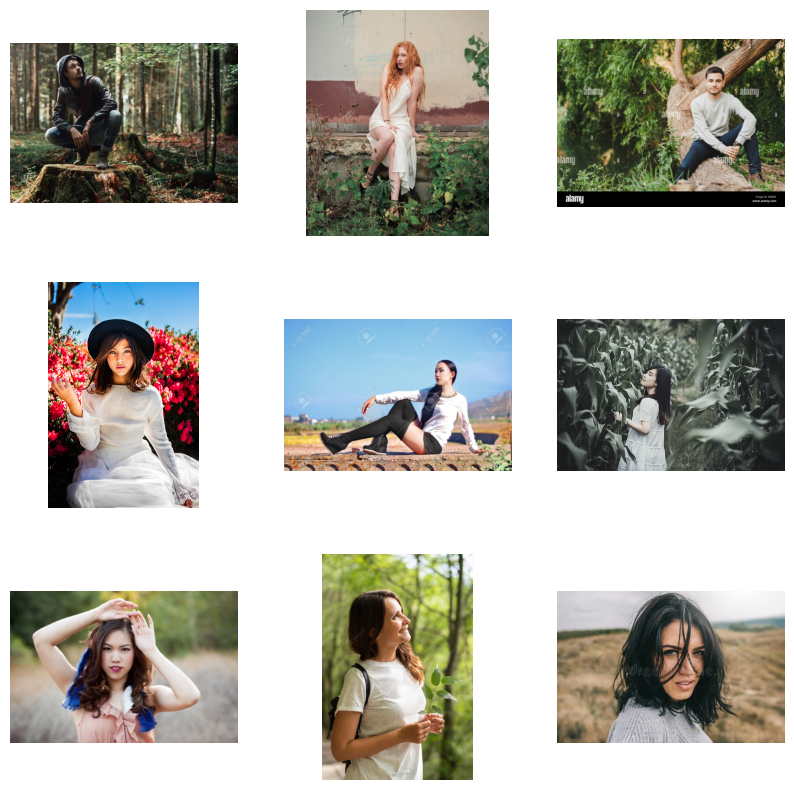

In [11]:
# present the first 9 images in a 3x3 grid.
plt.figure(figsize=(10, 10))
for i, image_file_path in enumerate(image_file_paths[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(load_img(image_file_path))
    plt.axis("off")

In [62]:
data = {}
for index, row in sorted_df.iterrows():
    img_name = row['image_name']
    if img_name not in data:
        data[img_name] = []
    data[img_name].append((row['x0'], row['y0'], row['x1'], row['y1']))

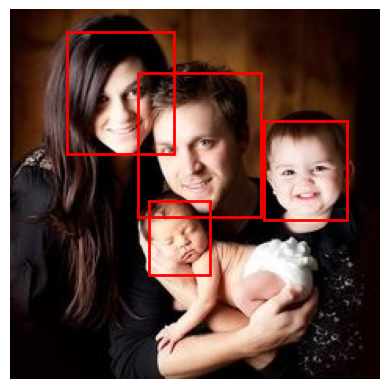

In [26]:
def plot_image_with_boxes(image_path, bounding_boxes):
    img = load_img(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in bounding_boxes:
        x0, y0, x1, y1 = bbox
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()

# Example usage
image_path = image_file_paths[2203]  # Change this to the path of your image
image_name = os.path.basename(image_path)
bounding_boxes = data[image_name]
plot_image_with_boxes(image_path, bounding_boxes)

In [65]:
new_bbox_after_resize = {}
for index, row in sorted_df.iterrows():
    img_name = row['image_name']
    width = row["width"]
    height = row["height"]
    width_ratio = 224/width
    height_ratio = 224/height
    if img_name not in new_bbox_after_resize:
        new_bbox_after_resize[img_name] = []
    new_bbox_after_resize[img_name].append((int(row['x0']*width_ratio), int(row['y0']*height_ratio), int(row['x1']*width_ratio), int(row['y1']*height_ratio)))

In [48]:
target_size = (224, 224)
resized_images = []

In [57]:
def plot_image_after_resize(image_path,target_size):
    img = load_img(image_path,target_size=target_size)
    image_name = os.path.basename(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    bounding_boxes = new_bbox_after_resize[image_name]
    for bbox in bounding_boxes:
        x0, y0, x1, y1 = bbox
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()
    

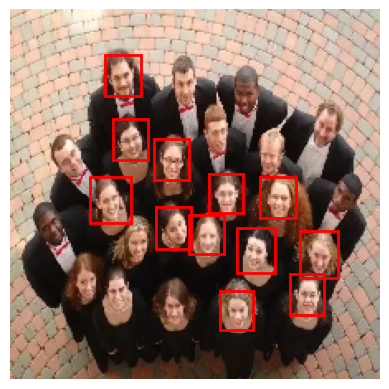

In [90]:
plot_image_after_resize(image_file_paths[295],target_size)

In [67]:
for image_path in image_file_paths:
    img = load_img(image_path,target_size=target_size)
    img_array = img_to_array(img)
    resized_images.append(img_array)

In [68]:
resized_images_arr = np.array(resized_images)

In [69]:
resized_images_arr.shape

(2204, 224, 224, 3)

In [71]:
rescaled_images = resized_images_arr.astype('float32') / 255.0

In [75]:
bounding_boxes = []

In [78]:
for img_name, bboxes in new_bbox_after_resize.items():
    coord = []
    for bbox in bboxes:
        for cord in bbox:
            coord.append(cord)
    bounding_boxes.append(coord)

In [92]:
max_bbox = 0
for i in range(len(bounding_boxes)):
    max_bbox = max(max_bbox, len(bounding_boxes[i]))

In [94]:
for i in range(len(bounding_boxes)):
    if int(max_bbox) - len(bounding_boxes[i]) != 0:
        for j in range(int(max_bbox) - len(bounding_boxes[i])):
            bounding_boxes[i].append(0)

In [97]:
bbox = np.array(bounding_boxes)

In [98]:
bbox.shape

(2204, 48)

In [100]:
X_train, X_temp, y_train, y_temp = train_test_split(rescaled_images, bbox, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [103]:
X_val.shape

(220, 224, 224, 3)

In [117]:
CNN_model = Sequential([
    Conv2D(32, 3, input_shape = (224,224,3), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48) #output layer
])

In [118]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_5 (Dropout)         (None, 109, 109, 64)     

In [119]:
CNN_model.compile(loss="mse",
              optimizer="adam",
              metrics=["accuracy"])

In [120]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_Face_Detection.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [121]:
history = CNN_model.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 110s 4s/step - loss: 1339.3672 - accuracy: 0.7215 - val_loss: 1549.5322 - val_accuracy: 0.7409
Epoch 2/50
28/28 [==============================] - 101s 4s/step - loss: 983.2216 - accuracy: 0.7618 - val_loss: 1366.1924 - val_accuracy: 0.7409
Epoch 3/50
28/28 [==============================] - 100s 4s/step - loss: 719.5601 - accuracy: 0.7618 - val_loss: 1096.2998 - val_accuracy: 0.7409
Epoch 4/50
28/28 [==============================] - 105s 4s/step - loss: 627.1389 - accuracy: 0.7618 - val_loss: 922.0137 - val_accuracy: 0.7409
Epoch 5/50
28/28 [==============================] - 104s 4s/step - loss: 601.8512 - accuracy: 0.7612 - val_loss: 881.9556 - val_accuracy: 0.7409
Epoch 6/50
28/28 [==============================] - 104s 4s/step - loss: 537.3743 - accuracy: 0.7618 - val_loss: 824.8350 - val_accuracy: 0.7409
Epoch 7/50
28/28 [==============================] - 100s 4s/step - loss: 497.6294 - accuracy: 0.7618 - val_loss: 822.7520 - va